In [1]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data
import matplotlib.pyplot as plt
import math
import scienceplots
import matplotlib as mpl
from tqdm import tqdm
import optuna

In [3]:
device = torch.device('cpu')

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device) 
y = np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2/10) + 1/ (x**2+1) + 0.12*torch.randn(x.size()).to(device)  # 这里是污染数据固定不变当成训练数据


# Define network
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x  

    def reset_parameters(self):
        # 重新初始化网络参数
        self.hidden1.reset_parameters()
        self.predict.reset_parameters()

# 自定义训练过程
def objective(trial):
    gradient_noise = trial.suggest_float('gradient_noise', 0.01, 0.3)
    lable_noise = trial.suggest_float('lable_noise', 0, 0.2)
    net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
    loss_func = torch.nn.MSELoss().to(device)
    NJnum = 10
    epoch = 15000
    train_losses = []
    
    for num in range(NJnum):
        seed = random.sample(range(1, 1000), 1)[0]#选择一个随机种子
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)

        net.reset_parameters()#每次实验前重置网络参数
        # 在标签 y 中添加噪声
        ytrain =y+lable_noise * torch.randn(x.size()).to(device)
        
        for _ in range(epoch):
            net.train()# 设定网络为训练模式
            prediction = net(x)
            loss = loss_func(prediction, y)
            optimizer.zero_grad()
            loss.backward()
            # 为梯度添加噪声
            with torch.no_grad():
                 for param in net.parameters():
                     param.grad += gradient_noise * torch.randn(param.grad.shape).to(param.grad.device)
            optimizer.step()
            
        train_losses.append(loss.item()) # 记录本次训练的损失值
        
    train_loss = np.mean(train_losses) # 计算平均训练损失
    
    # Test phase
    seeds = random.sample(range(1, 1000), 10)
    test_losses = []

    for seed in seeds:
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
        y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size())+lable_noise * torch.randn(x_test.size()).to(device)

        net.eval()# 设定网络为评估模式
        with torch.no_grad():
            prediction_test = net(x_test)
            test_loss = loss_func(prediction_test, y_test)
            test_losses.append(test_loss.item())

    mean_test_loss = np.mean(test_losses)

    return mean_test_loss

# Run optimization
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=SEED),  # Use TPE sampler with seed
    pruner=optuna.pruners.MedianPruner()  # Use median pruner for early stopping
)

study.optimize(objective, n_trials=20, show_progress_bar=True)


[I 2024-07-09 12:05:32,841] A new study created in memory with name: no-name-a6a9d015-670d-4bbe-bac0-5b2535d18552


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2024-07-09 12:07:21,233] Trial 0 finished with value: 0.04113035798072815 and parameters: {'gradient_noise': 0.06554064060987876, 'lable_noise': 0.12442175420796638}. Best is trial 0 with value: 0.04113035798072815.
[I 2024-07-09 12:09:07,963] Trial 1 finished with value: 0.06656114719808101 and parameters: {'gradient_noise': 0.1369410443120632, 'lable_noise': 0.15707171674275386}. Best is trial 0 with value: 0.04113035798072815.
[I 2024-07-09 12:10:54,993] Trial 2 finished with value: 0.03816370014101267 and parameters: {'gradient_noise': 0.23619298435445302, 'lable_noise': 0.054518521056528324}. Best is trial 2 with value: 0.03816370014101267.
[I 2024-07-09 12:12:41,857] Trial 3 finished with value: 0.05867910049855709 and parameters: {'gradient_noise': 0.09017463399149803, 'lable_noise': 0.16037443550700387}. Best is trial 2 with value: 0.03816370014101267.
[I 2024-07-09 12:14:28,482] Trial 4 finished with value: 0.07015009112656116 and parameters: {'gradient_noise': 0.2878604125

In [5]:
best_gradient_noise = study.best_params["gradient_noise"]
best_lable_noise = study.best_params["lable_noise"]
print(best_gradient_noise,best_lable_noise)

0.01214978586022278 0.04922874253481348


In [6]:
# 使用最佳参数重新训练模型
net = Net(n_feature=1, n_hidden1=14, n_output=1).to(device)
optimizer = torch.optim.Adam(net.parameters(), lr=0.01, betas=(0.99, 0.99))
loss_func = torch.nn.MSELoss().to(device)
# Define training settings
NJnum = 10
epoch = 15000


SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Define data
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
y=np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())

# Define x_respond for response plotting
x_respond = torch.unsqueeze(torch.linspace(-2, 10, 300), dim=1)

# Initialize lists to store losses and responses
train_losses = []
responses = []

# Training loop with noisy data
for num in range(NJnum):
    seed = random.sample(range(1, 10000), 1)[0]
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    net.reset_parameters()
    # 在标签 y 中添加噪声
    ytrain = y + best_lable_noise * torch.randn(x.size()).to(device)
    for t in range(epoch):
        net.train()
        prediction = net(x)
        loss = loss_func(prediction, y)
        optimizer.zero_grad()
        loss.backward()
        # 为梯度添加噪声
        with torch.no_grad():
             for param in net.parameters():
                 param.grad += best_gradient_noise * torch.randn(param.grad.shape).to(param.grad.device)
            
        optimizer.step()
        
    # Append the train loss
    train_losses.append(loss.item())
    
    # Calculate mean response for x_respond after training
    net.eval()
    with torch.no_grad():
        response = net(x_respond)
        responses.append(response.numpy())
        
# Calculate mean train loss
mean_train_loss = np.mean(train_losses)
# Calculate mean response across NJnum runs
mean_response = np.mean(responses, axis=0)

# Test phase
seeds = random.sample(range(1, 10000), 10)
test_losses = []

for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    x_test = torch.unsqueeze(torch.linspace(-2, 10, 30), dim=1).to(device)
    y_test = np.exp(-(x_test - 2)**2) + np.exp(-(x_test - 6)**2 / 10) + 1 / (x_test**2 + 1) + 0.12 * torch.randn(x_test.size()).to(device) + best_lable_noise * torch.randn(x_test.size()).to(device)


    net.eval()
    with torch.no_grad():
        prediction_test = net(x_test)
        test_loss = loss_func(prediction_test, y_test)
        test_losses.append(test_loss.item())

mean_test_loss = np.mean(test_losses)

print("Best noise:", best_gradient_noise,best_lable_noise)
print("Mean Test Loss:", mean_test_loss)
print("Mean Train Loss:", mean_train_loss)


Best noise: 0.01214978586022278 0.04922874253481348
Mean Test Loss: 0.021914509404450656
Mean Train Loss: 0.010600217245519161


In [7]:
# 将 x_respond 和 mean_response 保存到 CSV 文件
x_respond_np = x_respond.numpy()
output_data = np.hstack((x_respond_np, mean_response))
np.savetxt('D:/PycharmProjects/保存的参数/FOrestes（梯度和lable双优化）mean_response.csv', output_data, delimiter=',', header='x,mean_response', comments='')

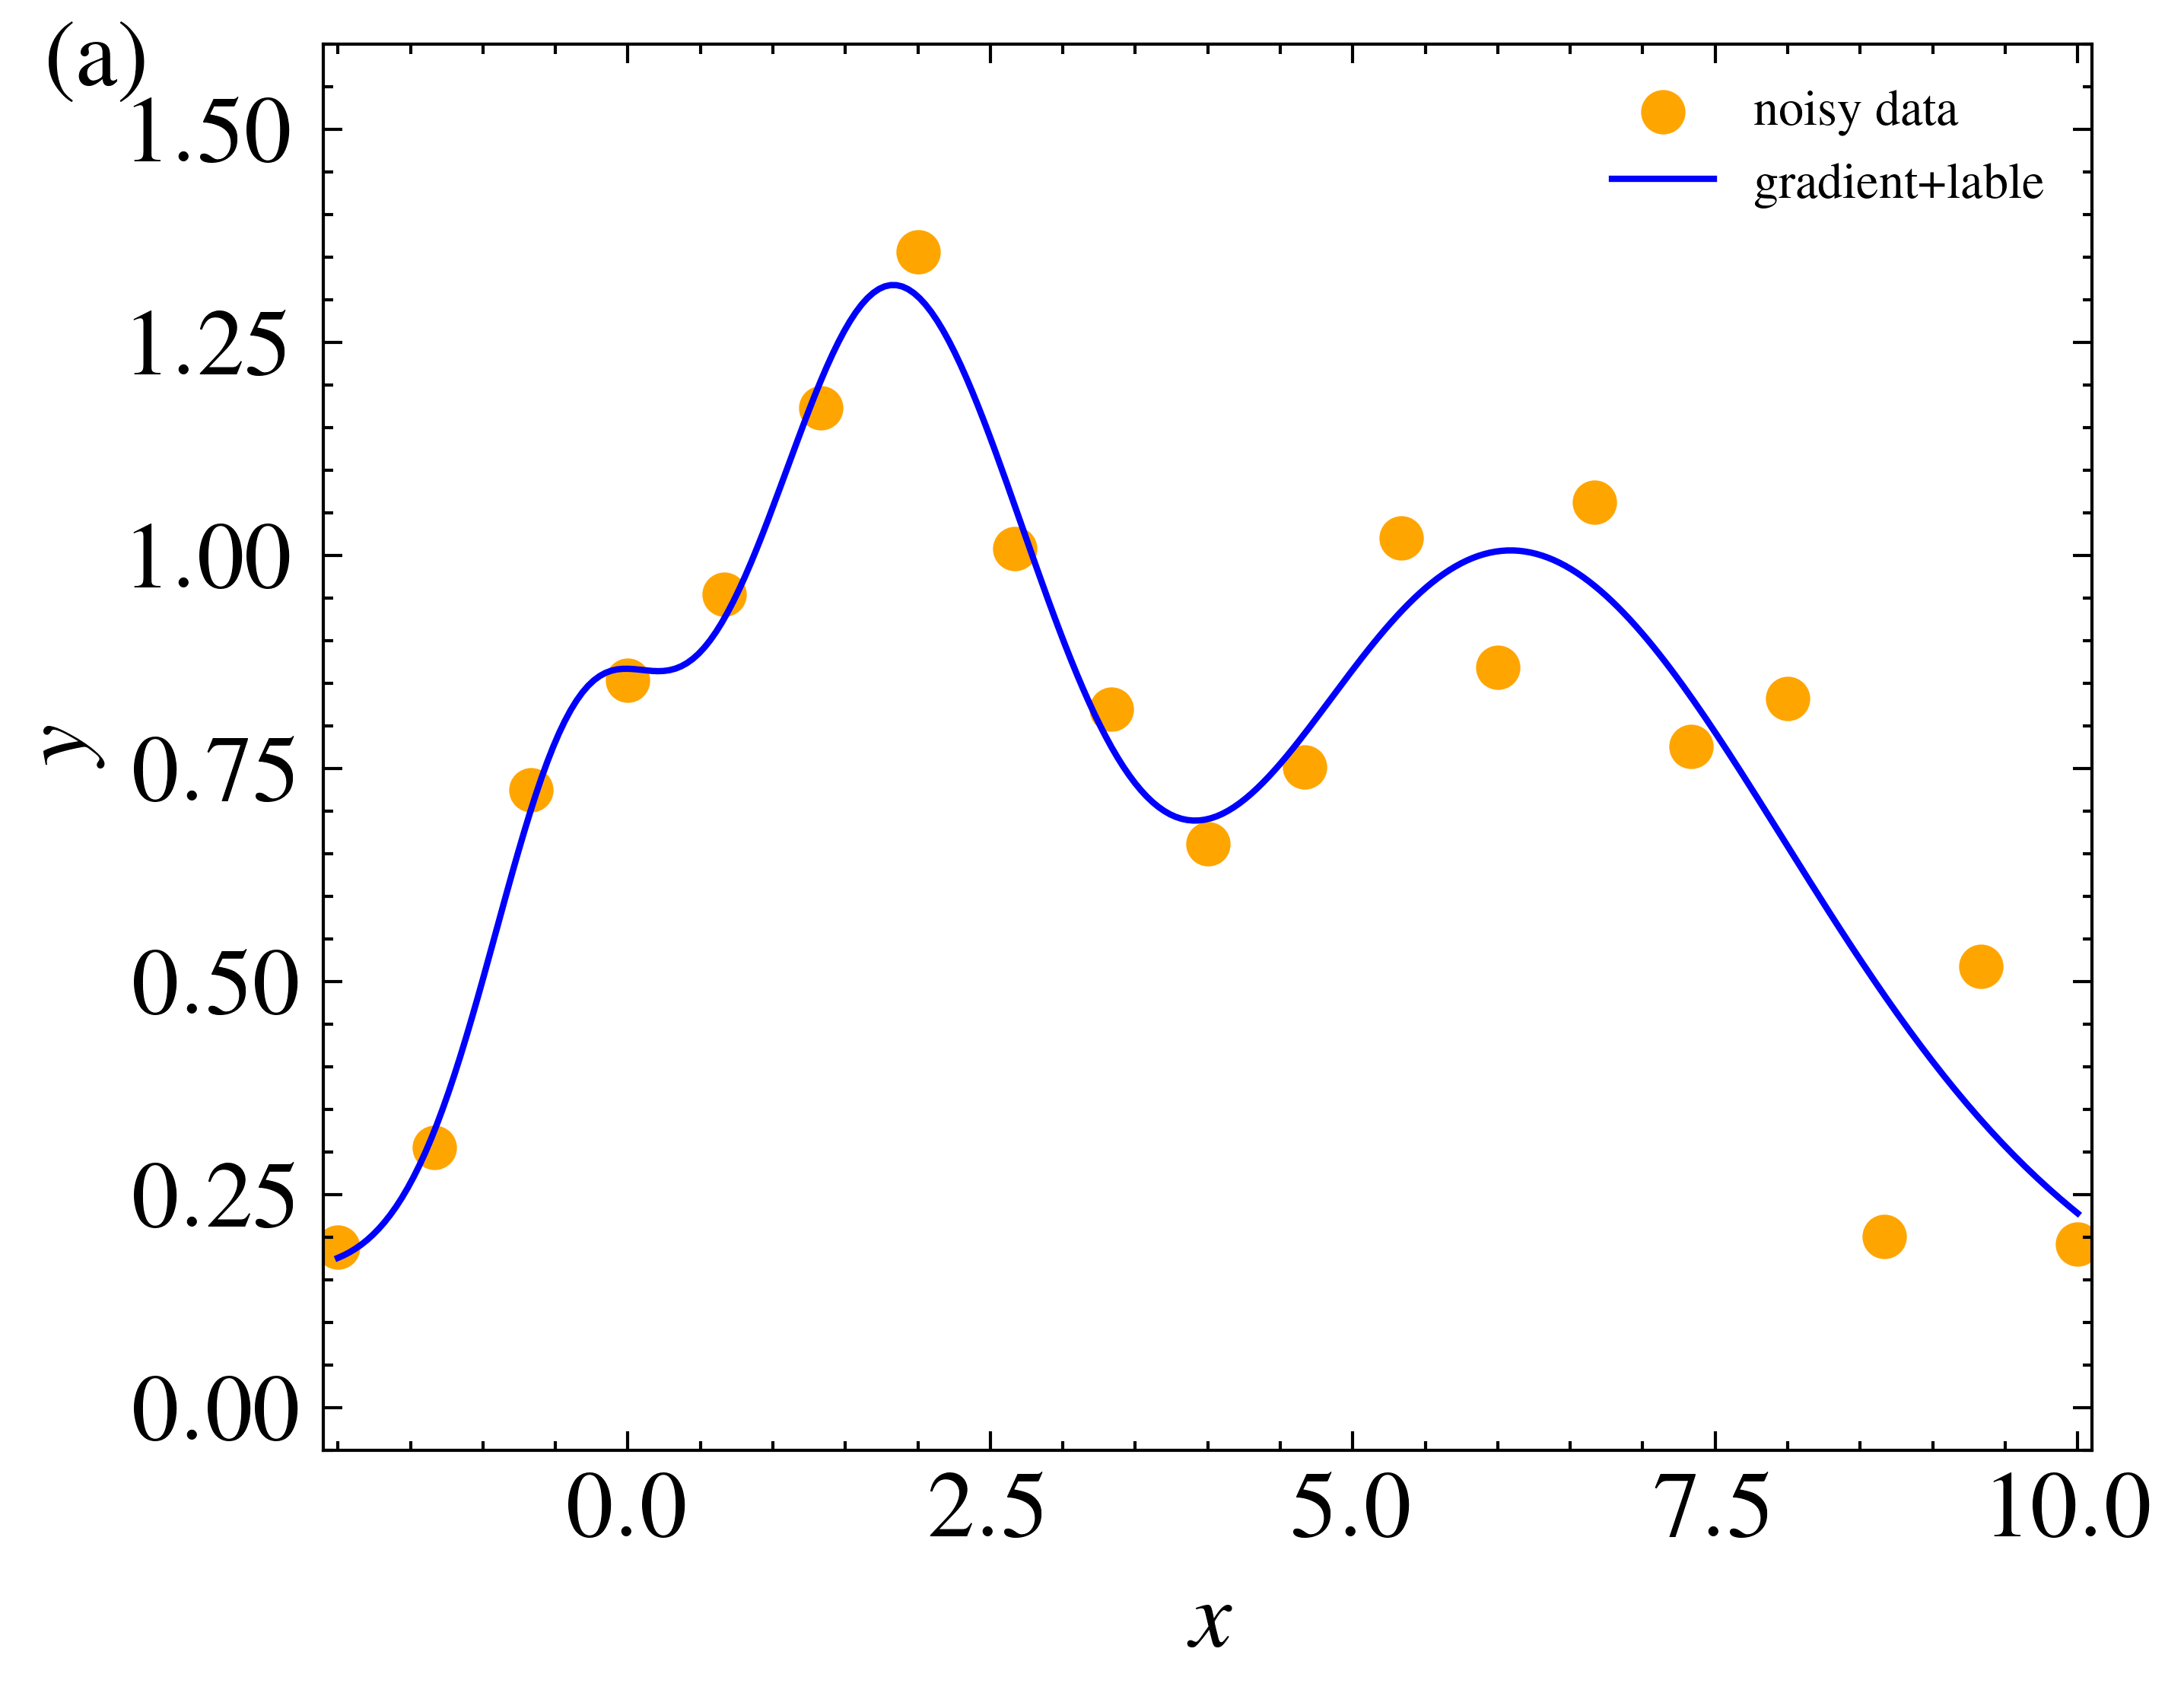

In [8]:
import matplotlib.pyplot as plt
import matplotlib as mpl

SEED = 1234
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

# Define data
x = torch.unsqueeze(torch.linspace(-2, 10, 19), dim=1).to(device)
y=np.exp(-(x - 2)**2) + np.exp(-(x - 6)**2 / 10) + 1 / (x**2 + 1) + 0.12 * torch.randn(x.size())

# Configure plot settings
plt.rcParams['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus'] = True
plt.style.use(['science', 'ieee'])
plt.rcParams['text.usetex'] = True
# Generate figure and axis
fig, ax = plt.subplots(figsize=(5, 4))
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('$x$', fontsize=15)
ax.set_ylabel('$y$', fontsize=15)
ax.set_xlim(-2.1, 10.1)
ax.set_ylim(-0.05, 1.6)

# Scatter plot for training set
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange", label='noisy data')

plt.plot(x_respond.numpy(), mean_response, label='gradient+lable', color='blue')

ax.text(-4, 1.55, '(a)',fontdict={'size': 15, 'color':  'black'})

plt.legend()
# plt.savefig('D:/PLA2024/Fig2c.eps', format='eps')
plt.show()